In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gpdm import GPDM
from dataset_utils.mocap_labels import RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
TRAIN_TRIALS = RUN_TRIALS_TRAIN
TEST_TRIALS = RUN_TRIALS_TEST
gpdm_save_name = "run_gpdm"

In [3]:
print(f"Number of train trials: {len(TRAIN_TRIALS)}")
print(f"Number of test trials: {len(TEST_TRIALS)}")

Number of train trials: 9
Number of test trials: 18


In [4]:
reduced_columns = TRAIN_TRIALS[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")


Number of DOFs: 35


In [5]:
train_dfs = [trial.as_dataframe() for trial in TRAIN_TRIALS]
train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::5, :] for df in train_dfs]


In [6]:
d = 3 # latent space dimension
DOFs = len(reduced_columns)  # number of degrees of freedom

dyn_back_step = 1 # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
y_lambdas_init = np.ones(DOFs)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)  # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)  # Linear coefficients for latent dynamics GP


In [7]:
gpdm = GPDM(
        D=DOFs,
        d=d,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [8]:
for train_arr in train_arrs:
    gpdm.add_data(train_arr)

print('Num. of sequences = '+str(gpdm.num_sequences)+' [Data points = '+str(np.concatenate(gpdm.observations_list, 0).shape[0])+']')


Num. of sequences = 9 [Data points = 276]



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 7.7276e+06
Update time: 0.10191631317138672

GPDM Opt. EPOCH: 10
Running loss: 2.8384e+06
Update time: 0.7019674777984619

GPDM Opt. EPOCH: 20
Running loss: 1.2175e+06
Update time: 0.7860524654388428

GPDM Opt. EPOCH: 30
Running loss: 6.1356e+05
Update time: 0.3751363754272461

GPDM Opt. EPOCH: 40
Running loss: 3.1374e+05
Update time: 0.33238744735717773

GPDM Opt. EPOCH: 50
Running loss: 1.6799e+05
Update time: 0.3271169662475586

GPDM Opt. EPOCH: 60
Running loss: 8.4824e+04
Update time: 0.457200288772583

GPDM Opt. EPOCH: 70
Running loss: 5.0386e+04
Update time: 0.3947641849517822

GPDM Opt. EPOCH: 80
Running loss: 3.8777e+04
Update time: 0.3543381690979004

GPDM Opt. EPOCH: 90
Running loss: 3.3474e+04
Update time: 0.3014364242553711

GPDM Opt. EPOCH: 100
Running loss: 3.0087e+04
Update time: 0.29791831970214844

GPDM Opt. EPOCH: 110
Running loss: 2.7365e+04
Update time: 0.3012557029724121

GPDM Opt. EPOCH: 120
Running 

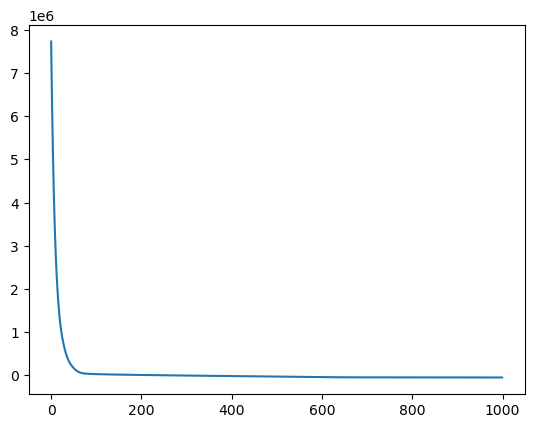

In [9]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=1000, num_print_steps=10, lr=0.05)

gpdm.save(f'{gpdm_save_name}_config.pth', f'{gpdm_save_name}_state.pth')  

plt.plot(losses)

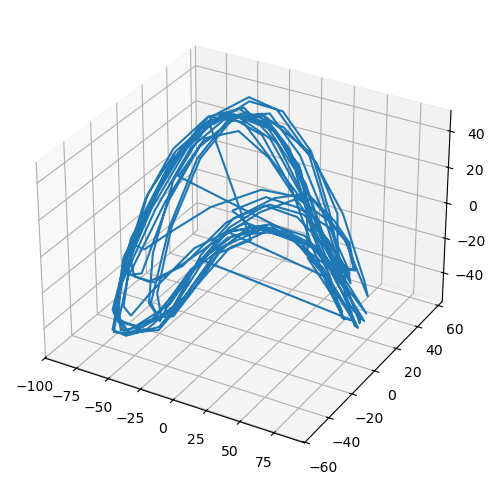

In [11]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X = gpdm.X.detach().numpy()
ax.plot(X[:, 0], X[:, 1], X[:, 2])